# Example: Regression with `QNNRegressor`

## Settings:
bo_aqc_func: EI
bo_bounds: (0.0, 0.3)
bo_aqc_optimizer: sampling


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skopt.space import Real
from squlearn import Executor
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam
from src.squlearn.encoding_circuit import ChebyshevRx
from src.squlearn.optimizers import SGLBO

We will use Qiskit's `StatevectorSimulator` for trainning.

In [2]:
executor = Executor("qasm_simulator")
executor.set_shots(10000)

In [3]:
x0 = [[i * 0.01] for i in range(14)]
options = {"lr": 0.4, "log_file": "log_3", "maxiter": 200}

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

In [4]:


nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 1, num_layers=number_of_layers)

We also need an observable

In [5]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

In [6]:
from skopt.space import Real

np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(pqc, ising_op, executor, SquaredLoss(), Adam(options), param_ini, param_op_ini)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [7]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

reg.fit(x_space, ref_values)

fit: 100%|██████████| 200/200 [2:00:27<00:00, 34.39s/it]  

## Evaluation

Let's check the trained parameters of the PQC and operator

In [8]:
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

Result PQC params: [ 0.74486682  0.18081242  2.85939183  0.58872712  2.17978557  0.65570985
  2.24993163 -0.99255301 -0.77005268  1.86129319  0.52783028 -0.2591075
 -1.34374163  2.35088168  0.99858532 -0.68032432]
Result operator params: [-1.30717884 -0.56325911  1.61662812]


Also let's plot the predicted function vs. the actual logarithm function

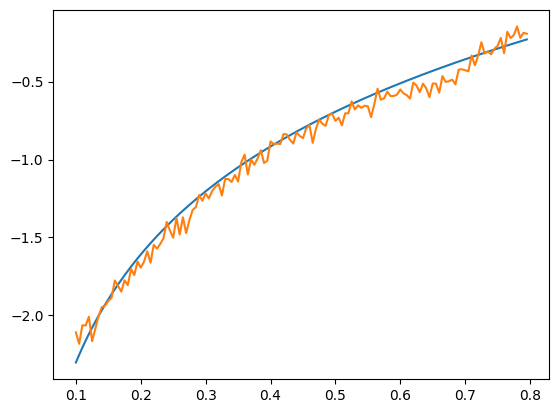

In [9]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

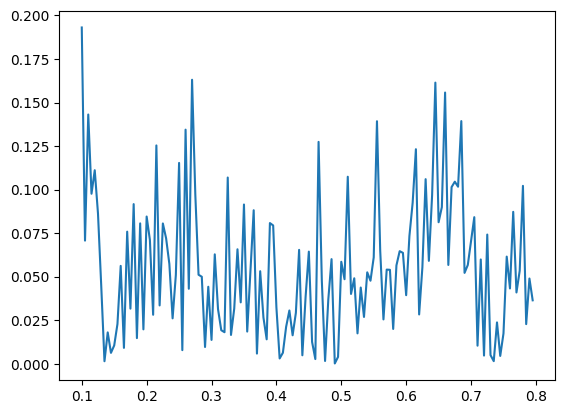

In [10]:
plt.plot(x, np.abs(y - np.log(x)))